# Feasibility modeling



A more complicated example involves minimizing in two dimensions, where some parts of the parameter space are off-limits. Let's minimize Himmelblau's function, subject to the constraint that $x_1^2 + x_2^2 < 50$

Text(0, 0.5, 'x2')

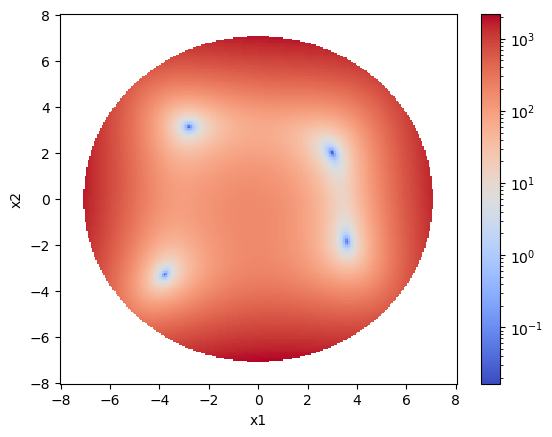

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from bloptools import test_functions

x1 = x2 = np.linspace(-8, 8, 256)
X1, X2 = np.meshgrid(x1, x2)
from bloptools.tasks import Task

task = Task(key="himmelblau", kind="min")
F = test_functions.constrained_himmelblau(X1, X2)

plt.pcolormesh(x1, x2, F, norm=mpl.colors.LogNorm(), shading="auto")
plt.colorbar()
plt.xlabel("x1")
plt.ylabel("x2")

where everything outside our constraint is undefined. In our digestion function, we return a `NaN` when we violate the constraint:

In [2]:
def digestion(db, uid):
    products = db[uid].table()

    for index, entry in products.iterrows():
        products.loc[index, "himmelblau"] = test_functions.constrained_himmelblau(entry.x1, entry.x2)

    return products

and create the agent in the usual way:



Transient Scan ID: 1     Time: 2023-08-11 02:23:18
Persistent Unique Scan ID: '8ff597d0-7dee-4aa2-a80e-68785dd2d8ca'


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 02:23:18.8 |      2.313 |     -1.469 |
|         2 | 02:23:18.8 |     -5.448 |      6.410 |
|         3 | 02:23:18.8 |     -3.556 |     -7.758 |
|         4 | 02:23:18.8 |      4.675 |      0.817 |
|         5 | 02:23:18.9 |      6.503 |     -4.018 |
|         6 | 02:23:18.9 |     -1.633 |      3.080 |
|         7 | 02:23:18.9 |     -7.371 |     -2.740 |
|         8 | 02:23:18.9 |      0.486 |      5.678 |
|         9 | 02:23:18.9 |      1.967 |     -6.035 |
|        10 | 02:23:18.9 |     -6.833 |      1.095 |
|        11 | 02:23:18.9 |     -0.163 |     -0.692 |
|        12 | 02:23:18.9 |      7.045 |      7.632 |
|        13 | 02:23:18.9 |      5.153 |     -3.454 |
|        14 | 02:23:18.9 |     -2.022 |      4.393 |
|        15 | 02:23:18.9 |     -4.974 |     -5.804 |
|        16 | 02:23:18.9

|        59 | 02:23:19.0 |     -1.982 |     -2.175 |
|        60 | 02:23:19.0 |      6.851 |      5.236 |
|        61 | 02:23:19.0 |      4.959 |     -1.914 |
|        62 | 02:23:19.1 |     -3.841 |      6.974 |
|        63 | 02:23:19.1 |     -5.171 |     -7.313 |
|        64 | 02:23:19.1 |      2.037 |      0.253 |
+-----------+------------+------------+------------+
generator list_scan ['8ff597d0'] (scan num: 1)





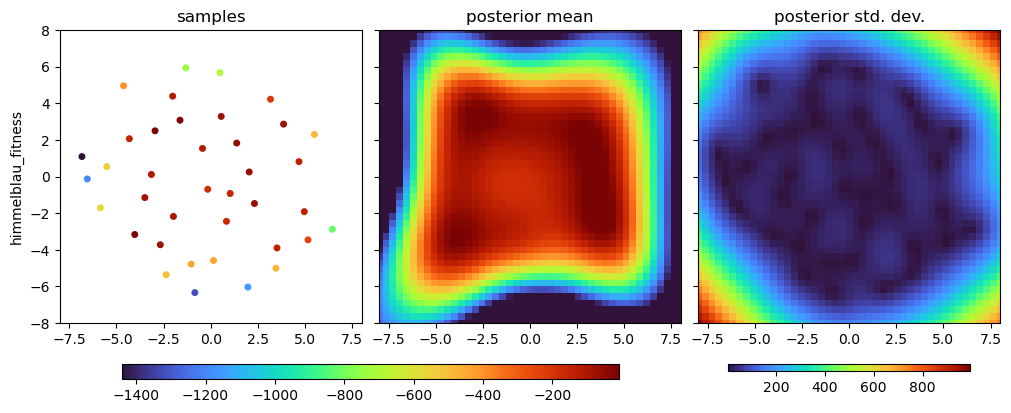

In [3]:
%run -i ../../../examples/prepare_bluesky.py # prepare the bluesky environment

from bloptools import devices
from bloptools.bayesian import Agent

dofs = [
    {"device": devices.DOF(name="x1"), "limits": (-8, 8), "kind": "active"},
    {"device": devices.DOF(name="x2"), "limits": (-8, 8), "kind": "active"},
]

tasks = [
    {"key": "himmelblau", "kind": "minimize"},
]

agent = Agent(
    dofs=dofs,
    tasks=tasks,
    digestion=digestion,
    db=db,
)

RE(agent.initialize("qr", n_init=64))

agent.plot_tasks()

In addition to modeling the fitness of the task, the agent models the probability that an input will be feasible:

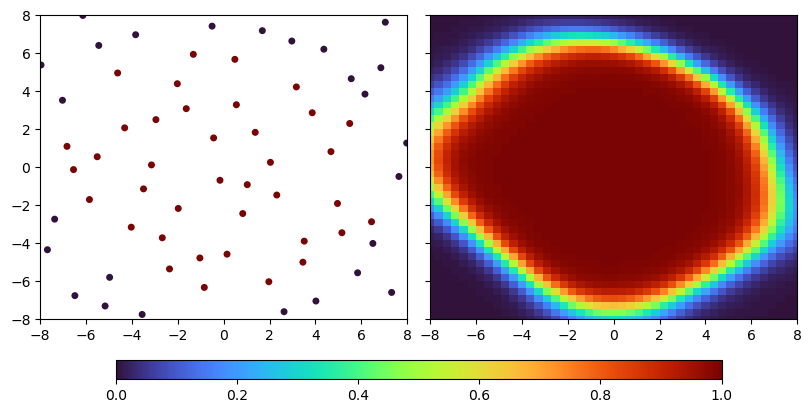

In [4]:
agent.plot_feasibility()

It combines the estimate of the objective and the estimate of the feasibility in deciding where to go:

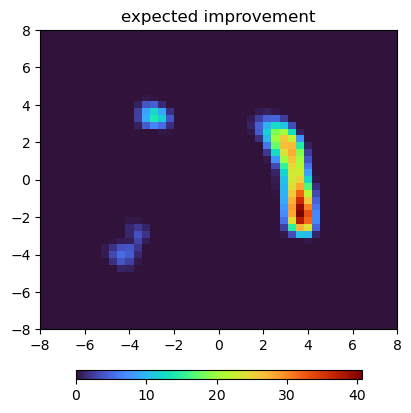

In [5]:
agent.plot_acquisition(acq_func=["ei", "pi", "ucb"])

In [6]:
RE(agent.learn("ei", n_per_iter=4))



Transient Scan ID: 2     Time: 2023-08-11 02:23:24
Persistent Unique Scan ID: '9561bd1a-3729-4715-824c-4bb2ff574f03'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 02:23:24.5 |      2.684 |      2.001 |
|         2 | 02:23:24.5 |      3.487 |      0.112 |
|         3 | 02:23:24.5 |      3.822 |     -1.734 |
|         4 | 02:23:24.5 |      8.000 |      8.000 |
+-----------+------------+------------+------------+
generator list_scan ['9561bd1a'] (scan num: 2)





('9561bd1a-3729-4715-824c-4bb2ff574f03',)

The agent automatically tries to avoid infeasible points, but will end up naturally exploring the boundary of the constraint. Let's see where the agent is thinking of going:

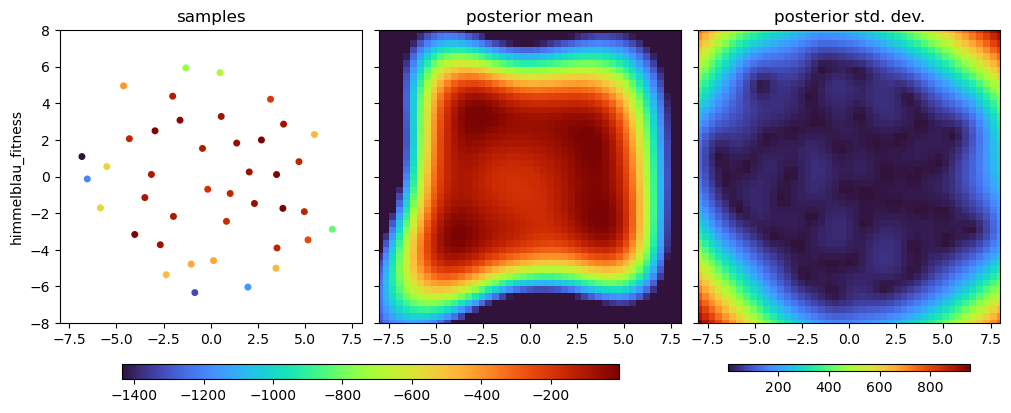

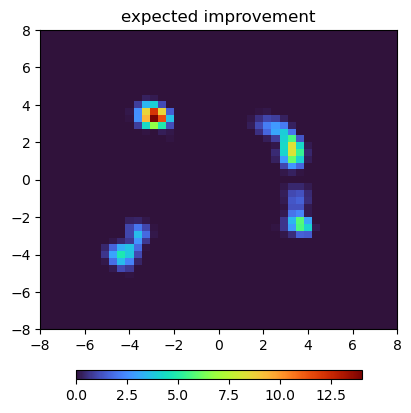

In [7]:
agent.plot_tasks()
agent.plot_acquisition(strategy=["ei", "pi", "ucb"])

The agent will naturally explore the whole parameter space



Transient Scan ID: 3     Time: 2023-08-11 02:23:27
Persistent Unique Scan ID: 'cb81fd9d-c910-4b68-b4b1-13d75cb0e07a'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 02:23:27.9 |      3.220 |      1.555 |
+-----------+------------+------------+------------+
generator list_scan ['cb81fd9d'] (scan num: 3)







Transient Scan ID: 4     Time: 2023-08-11 02:23:28
Persistent Unique Scan ID: 'ffc36eec-2687-42c9-a61e-5b613c88dad1'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 02:23:28.8 |     -2.872 |      3.381 |
+-----------+------------+------------+------------+
generator list_scan ['ffc36eec'] (scan num: 4)







Transient Scan ID: 5     Time: 2023-08-11 02:23:29
Persistent Unique Scan ID: 'f7a71ecd-afa3-43b4-a34c-8e871960d5f0'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 02:23:29.6 |     -5.321 |     -3.972 |
+-----------+------------+------------+------------+
generator list_scan ['f7a71ecd'] (scan num: 5)







Transient Scan ID: 6     Time: 2023-08-11 02:23:30
Persistent Unique Scan ID: '5f2f0812-9dc5-4310-8d9b-04dec9c13fcb'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 02:23:30.3 |      3.558 |     -2.124 |
+-----------+------------+------------+------------+
generator list_scan ['5f2f0812'] (scan num: 6)







Transient Scan ID: 7     Time: 2023-08-11 02:23:31
Persistent Unique Scan ID: '74e8683e-6c1d-426f-8e49-02fee3d9795b'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 02:23:31.3 |      2.224 |      3.103 |
+-----------+------------+------------+------------+
generator list_scan ['74e8683e'] (scan num: 7)







Transient Scan ID: 8     Time: 2023-08-11 02:23:32
Persistent Unique Scan ID: 'ad4b40d6-e2ce-464f-8239-a9c3f56a2c79'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 02:23:32.1 |     -2.543 |      3.114 |
+-----------+------------+------------+------------+
generator list_scan ['ad4b40d6'] (scan num: 8)







Transient Scan ID: 9     Time: 2023-08-11 02:23:32
Persistent Unique Scan ID: '4217aefe-3f8e-41af-a5fc-125fc0f05bea'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 02:23:32.9 |      3.388 |      1.962 |
+-----------+------------+------------+------------+
generator list_scan ['4217aefe'] (scan num: 9)







Transient Scan ID: 10     Time: 2023-08-11 02:23:33
Persistent Unique Scan ID: '9b5750c5-712a-4743-8d10-3af20c74884a'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 02:23:33.7 |     -3.720 |     -3.619 |
+-----------+------------+------------+------------+
generator list_scan ['9b5750c5'] (scan num: 10)







Transient Scan ID: 11     Time: 2023-08-11 02:23:34
Persistent Unique Scan ID: 'e492af68-882e-47c9-862e-eb9f7c364223'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 02:23:34.8 |     -3.754 |     -3.012 |
+-----------+------------+------------+------------+
generator list_scan ['e492af68'] (scan num: 11)







Transient Scan ID: 12     Time: 2023-08-11 02:23:35
Persistent Unique Scan ID: 'f7bdf560-94b1-4588-8baa-8290caa29778'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 02:23:35.6 |      3.875 |     -2.536 |
+-----------+------------+------------+------------+
generator list_scan ['f7bdf560'] (scan num: 12)







Transient Scan ID: 13     Time: 2023-08-11 02:23:36
Persistent Unique Scan ID: '9c5c6627-3a55-49bd-971c-1c97a13ff4b8'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 02:23:36.6 |      3.395 |     -1.714 |
+-----------+------------+------------+------------+
generator list_scan ['9c5c6627'] (scan num: 13)







Transient Scan ID: 14     Time: 2023-08-11 02:23:37
Persistent Unique Scan ID: 'a5068c3a-4141-4cad-ad81-9729e9277782'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 02:23:37.5 |      2.562 |      2.342 |
+-----------+------------+------------+------------+
generator list_scan ['a5068c3a'] (scan num: 14)







Transient Scan ID: 15     Time: 2023-08-11 02:23:38
Persistent Unique Scan ID: '1708b150-075b-4b6a-9420-0a67d146af5d'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 02:23:38.2 |     -2.328 |      3.489 |
+-----------+------------+------------+------------+
generator list_scan ['1708b150'] (scan num: 15)







Transient Scan ID: 16     Time: 2023-08-11 02:23:39
Persistent Unique Scan ID: '78ac9ff2-6665-4e0f-87ac-0e863738c906'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 02:23:39.2 |      3.595 |     -1.518 |
+-----------+------------+------------+------------+
generator list_scan ['78ac9ff2'] (scan num: 16)







Transient Scan ID: 17     Time: 2023-08-11 02:23:40
Persistent Unique Scan ID: '9a4f98ab-6ad4-446e-84e8-98599671ae92'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 02:23:40.1 |     -1.167 |      0.147 |
+-----------+------------+------------+------------+
generator list_scan ['9a4f98ab'] (scan num: 17)







Transient Scan ID: 18     Time: 2023-08-11 02:23:41
Persistent Unique Scan ID: 'f1396dd2-f056-4156-baf6-7f0fabb793c7'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |
+-----------+------------+------------+------------+
|         1 | 02:23:41.0 |      3.696 |     -1.093 |
+-----------+------------+------------+------------+
generator list_scan ['f1396dd2'] (scan num: 18)





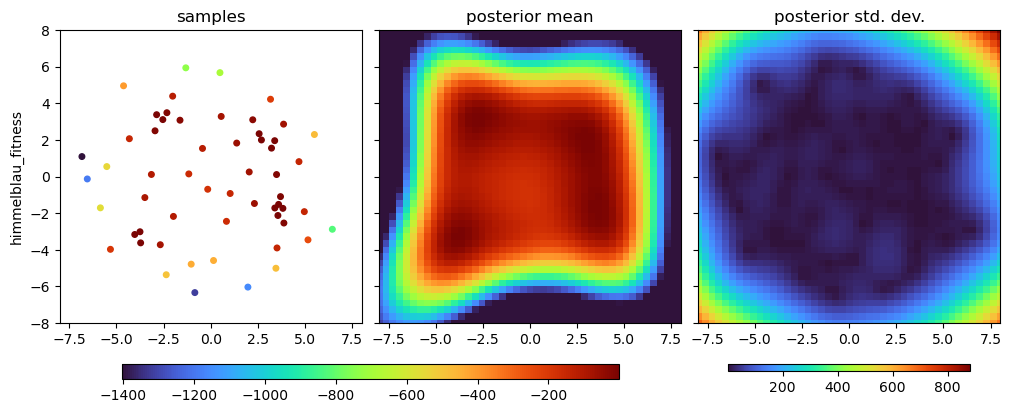

In [8]:
RE(agent.learn("ei", n_iter=16))
agent.plot_tasks()